In [ ]:
import sys
sys.path.append('../../')

from utils.Library import *
from utils.DataLoader import load_data

cols_to_drop = ['text', 'advanced_text', 'policy', 'antibiotics', 'self_empl', 'days_at_home', 
                'text_hist', 'text_phys_exam', 'advanced_text_hist','advanced_text_phys_exam',
                'phys_emb', 'adv_hist_emb', 'adv_phys_emb',
               ]

train_df, test_df = load_data(
    train_path='../../data/train_8000_final.p',
    test_path='../../data/test_2000_final.p',
    cols_to_drop=cols_to_drop
)


In [10]:
#background: season, policy, self-empl
#diagnosis: pneu, cold
#underlying condition: asthma, smoking, COPD
#symptoms: dyspnea, cough, pain, fever, nasal

BN = BayesianNetwork([
    ('smoking', 'COPD'),
    ('smoking', 'cough'),
    ('smoking', 'dysp'),
    ('asthma', 'dysp'),
    ('asthma', 'pneu'),
    ('asthma', 'cough'),
    ('hay_fever', 'dysp'),
    ('hay_fever', 'nasal'),
    ('COPD', 'pneu'),
    ('COPD', 'dysp'),
    ('COPD', 'cough'),
    ('COPD', 'pain'),
    ('winter', 'pneu'),
    ('winter', 'inf'),
    ('pneu', 'dysp'),
    ('pneu', 'cough'),
    ('pneu', 'pain'),
    ('pneu', 'fever'),
    ('inf', 'cough'),
    ('inf', 'pain'),
    ('pneu', 'fever'),
    ('pneu', 'nasal'),
    ('cough', 'pain'),
    #('policy','antibiotics'),
    #('self_empl','days_at_home')
])

def BN_model_train(train_df, test_df, target):
    print(f"🔹 Đang chạy với target: {target}")

    # Chuyển đổi nhãn thành 0 và 1
    train_df[target] = train_df[target]
    test_df[target] = test_df[target]

    # Huấn luyện mô hình
    BN.fit(train_df, estimator=BayesianEstimator)

    # Khởi tạo suy diễn
    inference = VariableElimination(BN)

    # Dự đoán trên tập test
    test_features = test_df.drop(columns=[target])
    y_true = test_df[target].values
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in test_features.iterrows()
    ])

    # Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Vẽ đồ thị
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Train ROC Curve for " + target)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()

    return BN

In [11]:
def NN_model_train(symt, df_train, df_test, emb='hist_emb'):
    """
    Huấn luyện mô hình NN cho một triệu chứng cụ thể.

    Args:
        symt (str): Tên triệu chứng cần huấn luyện.
        df_train (DataFrame): Tập huấn luyện.
        df_test (DataFrame): Tập kiểm tra.

    Returns:
        Tuple: (precision, recall, f1, accuracy), model đã huấn luyện.
    """
    # Chuyển embeddings từ dạng list thành numpy array
    X_train = np.array(df_train[emb].tolist())
    X_test = np.array(df_test[emb].tolist())

    # Xử lý nhãn (label)
    if symt == 'fever':  # Nếu là bài toán nhiều lớp
        y_train = to_categorical(df_train[symt].values, num_classes=3)
        y_test = to_categorical(df_test[symt].values, num_classes=3)
    else:  # Nếu là bài toán nhị phân
        y_train = df_train[symt].values  # Đảm bảo y_train là numpy array
        y_test = df_test[symt].values  

    print("y_train shape:", y_train.shape)
    
    # Định nghĩa model
    model = Sequential([
        Dense(768, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        Dense(3 if symt == 'fever' else 1, activation='relu' if symt == 'fever' else 'sigmoid')
    ])

    # Chọn loss function
    loss = 'categorical_crossentropy' if symt == 'fever' else 'binary_crossentropy'
    model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])
    
    model.summary()

    # Tính trọng số của từng class
    if symt == 'fever':
        class_weights = compute_class_weight('balanced', classes=np.unique(df_train[symt]), y=df_train[symt])
        class_weights = {i: class_weights[i] for i in range(len(class_weights))}
    else:
        class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
        class_weights = {0: class_weights[0], 1: class_weights[1]}

    print("Class Weights:", class_weights)

    # Huấn luyện mô hình
    model.fit(X_train, y_train, epochs=15, batch_size=100, validation_split=0.2, class_weight=class_weights)

    # Dự đoán trên tập kiểm tra
    y_pred_prob = model.predict(X_test)

    # Chuyển đổi kết quả dự đoán
    if symt == 'fever':
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_test_labels = np.argmax(y_test, axis=1)  
    else:
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        y_test_labels = y_test  

    # Tính độ đo đánh giá
    precision = precision_score(y_test_labels, y_pred, average='weighted' if symt == 'fever' else 'binary')
    recall = recall_score(y_test_labels, y_pred, average='weighted' if symt == 'fever' else 'binary')
    f1 = f1_score(y_test_labels, y_pred, average='weighted' if symt == 'fever' else 'binary')
    accuracy = accuracy_score(y_test_labels, y_pred)

    scores = [precision, recall, f1, accuracy]
    return scores, model

In [12]:
def test(BN, NN_models, test_df, target, emb='hist_emb'):
    """
    Kiểm tra mô hình bằng cách chạy tập test qua 5 mô hình NN riêng biệt,
    sau đó sử dụng BN để đưa ra dự đoán cuối cùng.

    Args:
        BN: Mô hình Bayesian Network đã được huấn luyện.
        NN_models: Dictionary chứa 5 mô hình Neural Network cho từng triệu chứng.
        test_df: DataFrame chứa tập test, phải có cột 'emb'.
        target: Biến mục tiêu cần dự đoán.
        emb: Tên cột chứa embedding.

    Returns:
        y_pred: Dự đoán cuối cùng từ BN.
        y_true: Nhãn thực tế.
    """
    # Bước 1: Kiểm tra embeddings
    if emb not in test_df:
        raise ValueError(f"Lỗi: Không tìm thấy cột '{emb}' trong test_df!")

    test_df = test_df.dropna(subset=[emb]).reset_index()  # Lưu lại index gốc
    original_index = test_df['index']

    X_text = np.array(test_df[emb].tolist())  # Chuyển Series thành numpy array
    if X_text.ndim == 1:
        X_text = np.expand_dims(X_text, axis=1)  # Chuyển thành (N, D)

    # Bước 2: Trích xuất đặc trưng từ các mô hình NN
    symptoms = ["dysp", "cough", "pain", "fever", "nasal"]
    predictions = {}

    for symptom in symptoms:
        model = NN_models.get(symptom, None)
        if model is None:
            raise ValueError(f"Lỗi: Không tìm thấy mô hình cho triệu chứng '{symptom}'!")

        pred = model.predict(X_text).round(0)

        # Xử lý riêng cho fever (có 3 lớp)
        if symptom == "fever":
            pred = np.argmax(pred, axis=1)  # Lấy nhãn có xác suất cao nhất (0, 1, 2)
        else:
            pred = pred.flatten()  # Đảm bảo output có shape (N,)

        print(f"{symptom} - Output shape: {pred.shape}")  # Debug

        # Lưu lại dự đoán với index gốc
        predictions[symptom] = pd.Series(pred, index=test_df.index)

    # Bước 3: Chuyển kết quả dự đoán thành DataFrame
    feature_df = pd.DataFrame(predictions)

    # Bước 4: Ghép với đặc trưng nền từ test_df
    X_background = test_df.iloc[:, :5].drop(columns=['index'], errors='ignore')
    feature_df = pd.concat([X_background, feature_df], axis=1)
    # Bước 4: Suy diễn Bayes
    inference = VariableElimination(BN)

    y_true = test_df[target].values
    
    y_pred = np.array([
        inference.query(variables=[target], evidence=row.to_dict()).values[1]  
        for _, row in feature_df.iterrows()
    ])
    
    # Bước 5: Tính ROC và PR Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall, precision)

    # Bước 6: Vẽ đồ thị
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Test ROC Curve for " + target)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve for " + target)
    plt.legend()
    
    plt.show()
    
    return y_pred, y_true

y_train shape: (8000,)


C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,713 (3.00 MB)

 Trainable params: 787,713 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6258801439524331, 1: 2.4860161591050343}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8683 - loss: 0.3924 - val_accuracy: 0.9444 - val_loss: 0.1533
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9496 - loss: 0.1679 - val_accuracy: 0.9675 - val_loss: 0.1044
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9594 - loss: 0.1424 - val_accuracy: 0.9594 - val_loss: 0.1132
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9696 - loss: 0.1028 - val_accuracy: 0.9663 - val_loss: 0.1013
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9706 - loss: 0.1003 - val_accuracy: 0.9606 - val_loss: 0.1117
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9750 - loss: 0.0896 - val_accuracy: 0.9613 - val_loss: 0.1083
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9738 - loss: 0.0825 - val_accuracy: 0.9281 - val_loss: 0.1766
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,713 (3.00 MB)

 Trainable params: 787,713 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.7590132827324478, 1: 1.465201465201465}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8400 - loss: 0.3970 - val_accuracy: 0.9325 - val_loss: 0.1846
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9456 - loss: 0.1533 - val_accuracy: 0.9475 - val_loss: 0.1475
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9611 - loss: 0.1168 - val_accuracy: 0.9631 - val_loss: 0.1280
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9663 - loss: 0.1018 - val_accuracy: 0.9650 - val_loss: 0.1130
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9763 - loss: 0.0808 - val_accuracy: 0.9688 - val_loss: 0.1194
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9737 - loss: 0.0792 - val_accuracy: 0.9700 - val_loss: 0.1011
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9764 - loss: 0.0713 - val_accuracy: 0.9613 - val_loss: 0.1081
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,713 (3.00 MB)

 Trainable params: 787,713 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.5771172990910403, 1: 3.7418147801683816}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7399 - loss: 0.5221 - val_accuracy: 0.9025 - val_loss: 0.2525
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8659 - loss: 0.3345 - val_accuracy: 0.8806 - val_loss: 0.3036
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8905 - loss: 0.2928 - val_accuracy: 0.8244 - val_loss: 0.3637
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8911 - loss: 0.2847 - val_accuracy: 0.8469 - val_loss: 0.3372
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8870 - loss: 0.2854 - val_accuracy: 0.9438 - val_loss: 0.1857
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9169 - loss: 0.2422 - val_accuracy: 0.9287 - val_loss: 0.2023
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9304 - loss: 0.2086 - val_accuracy: 0.8781 - val_loss: 0.2826
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 788,227 (3.01 MB)

 Trainable params: 788,227 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.42381860563678747, 1: 2.072002072002072, 2: 6.334125098970705}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7713 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7823 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7763 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7760 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7839 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7791 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7870 - loss: nan - val_accuracy: 0.7975 - val_loss: nan
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7865 - los

C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\HP VICTUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,713 (3.00 MB)

 Trainable params: 787,713 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

Class Weights: {0: 0.6667777962993833, 1: 1.999000499750125}
Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7998 - loss: 0.3798 - val_accuracy: 0.9644 - val_loss: 0.1247
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9572 - loss: 0.1543 - val_accuracy: 0.9556 - val_loss: 0.1384
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9664 - loss: 0.1117 - val_accuracy: 0.9706 - val_loss: 0.1095
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9741 - loss: 0.1000 - val_accuracy: 0.9631 - val_loss: 0.1221
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9731 - loss: 0.0960 - val_accuracy: 0.9744 - val_loss: 0.0916
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9789 - loss: 0.0908 - val_accuracy: 0.9525 - val_loss: 0.1589
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9764 - loss: 0.0922 - val_accuracy: 0.9681 - val_loss: 0.0987
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - acc

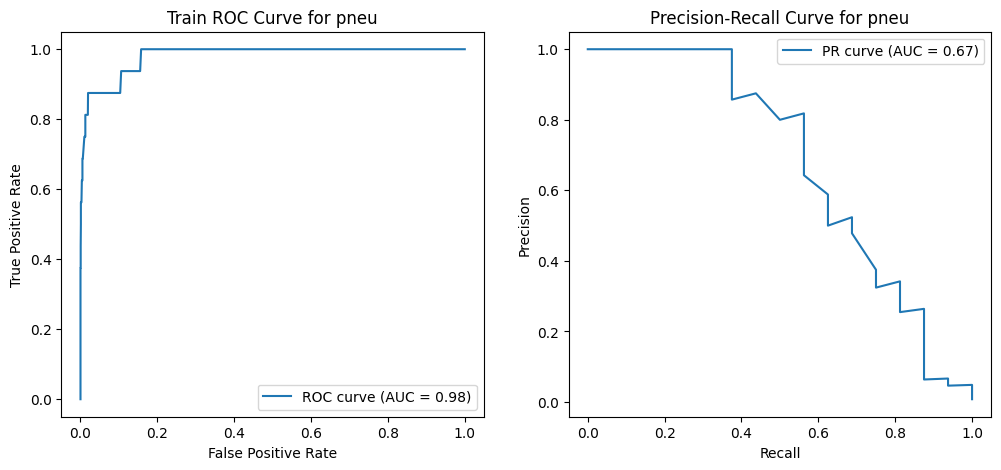

🔹 Đang chạy với target: inf


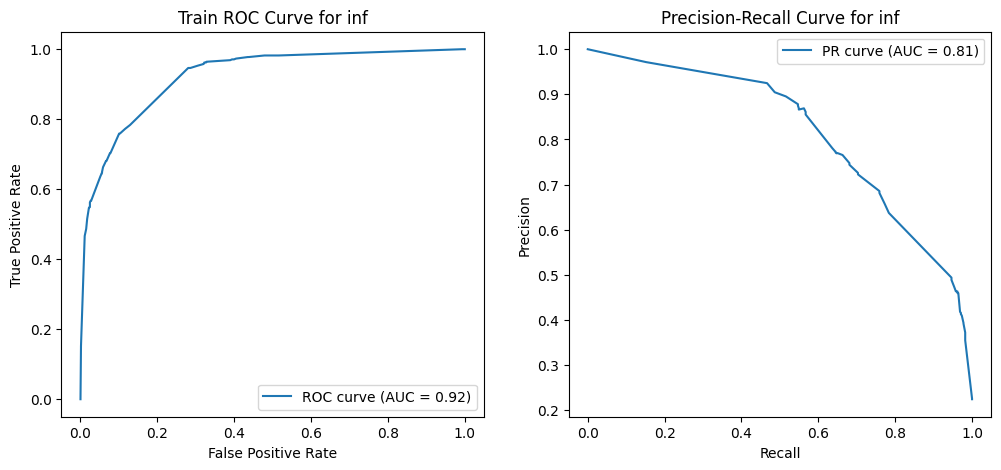

In [13]:
### TRAIN Text for 5 symps
symptoms = ["dysp", "cough", "pain", "fever", "nasal"]

result = pd.DataFrame(columns=["precision", "recall", "f1", "accuracy"])
NN_models = {}

for i in symptoms:
    metrics, model = NN_model_train(i, train_df, test_df)  # Đảm bảo NN_model_train trả về tuple
    result.loc[len(result)] = metrics  # Gán giá trị metrics vào hàng mới
    NN_models[i] = model  # Lưu mô hình vào dictionary
    
### TRAIN BN for pneu/inf
targets = ["pneu", "inf"]
BN_models = {
    'pneu': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "pneu"),
    'inf': BN_model_train(train_df.iloc[:, :12], test_df.iloc[:, :12], "inf")
}

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
nasal - Output shape: (2000,)


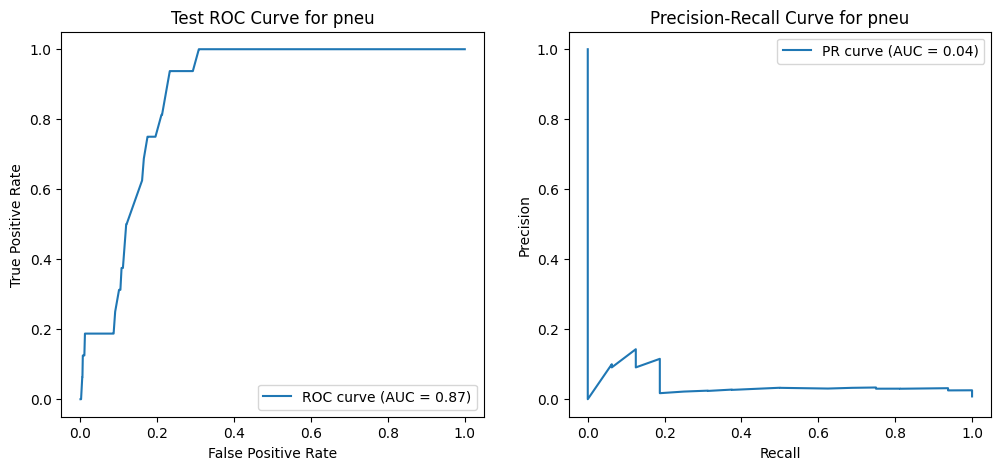

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
nasal - Output shape: (2000,)


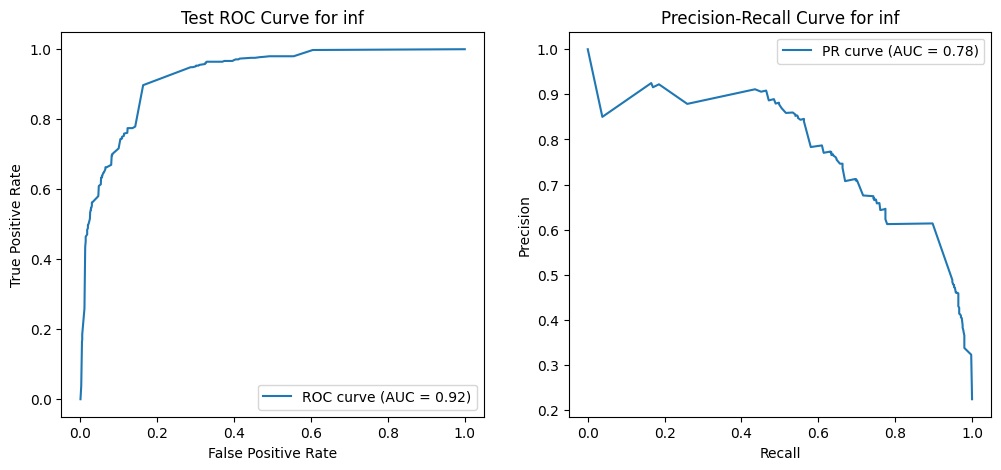

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


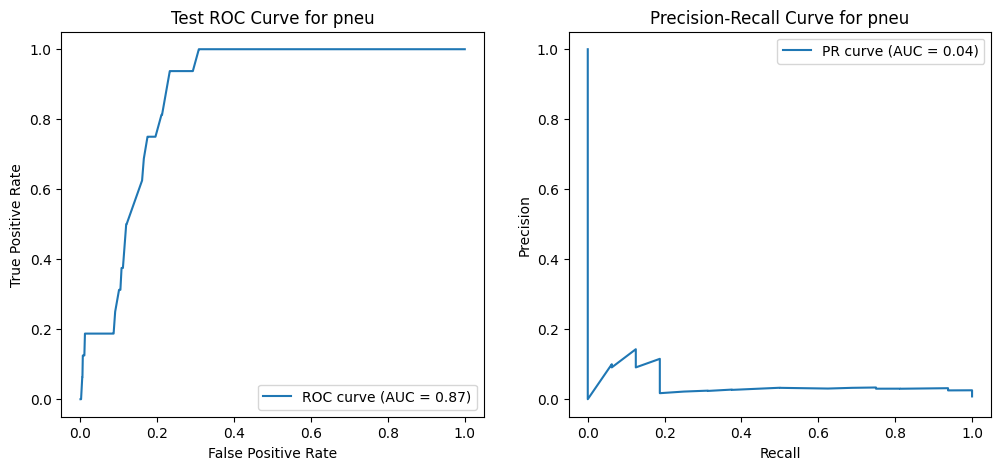

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


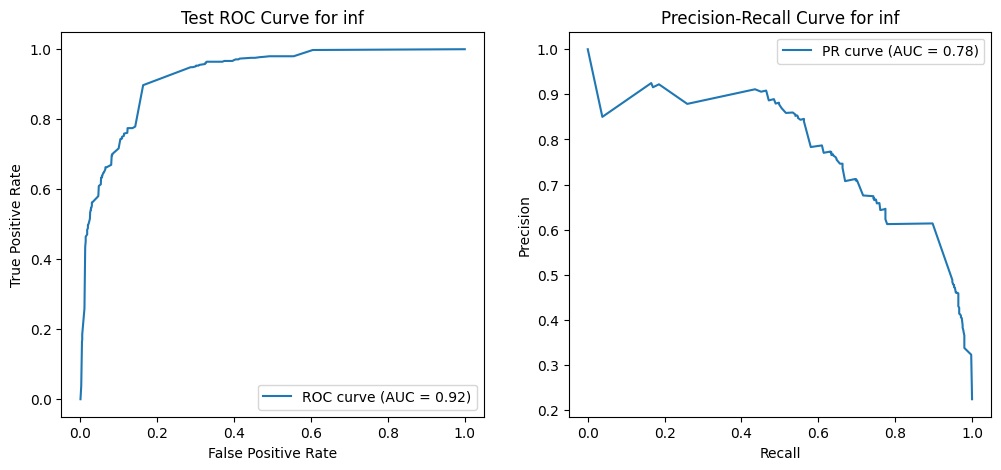

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


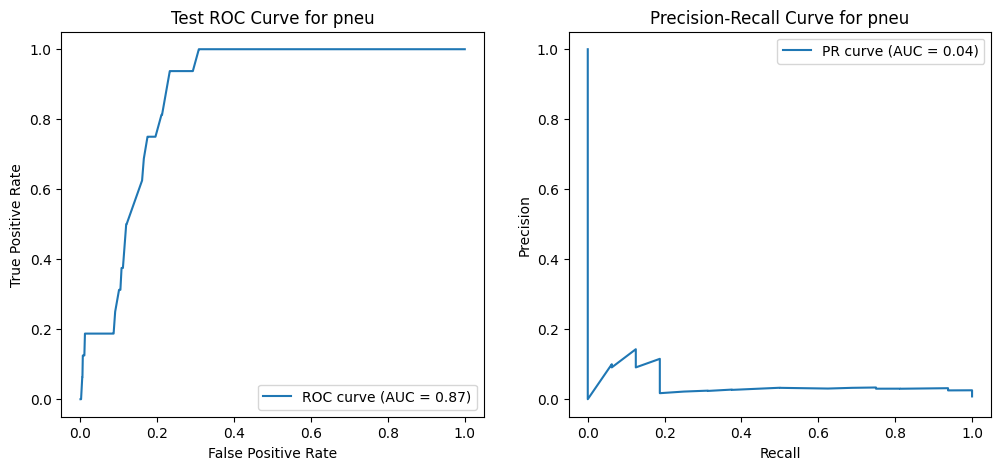

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


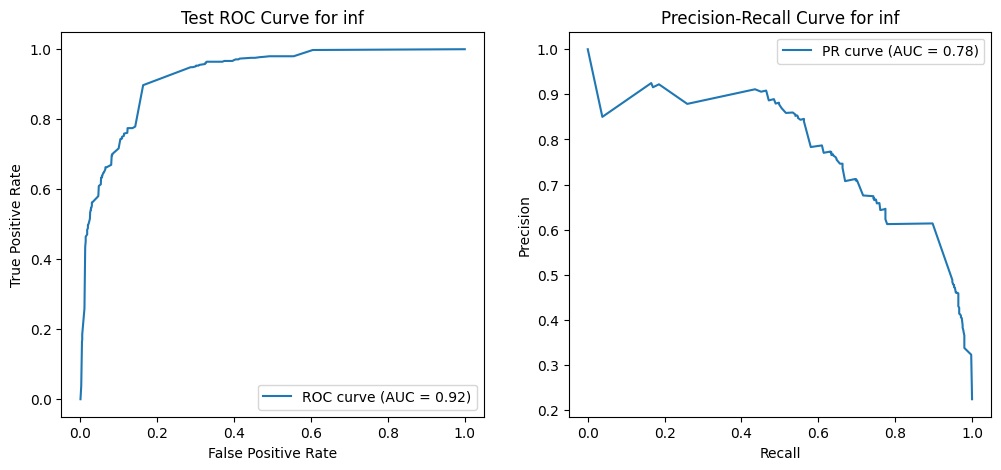

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


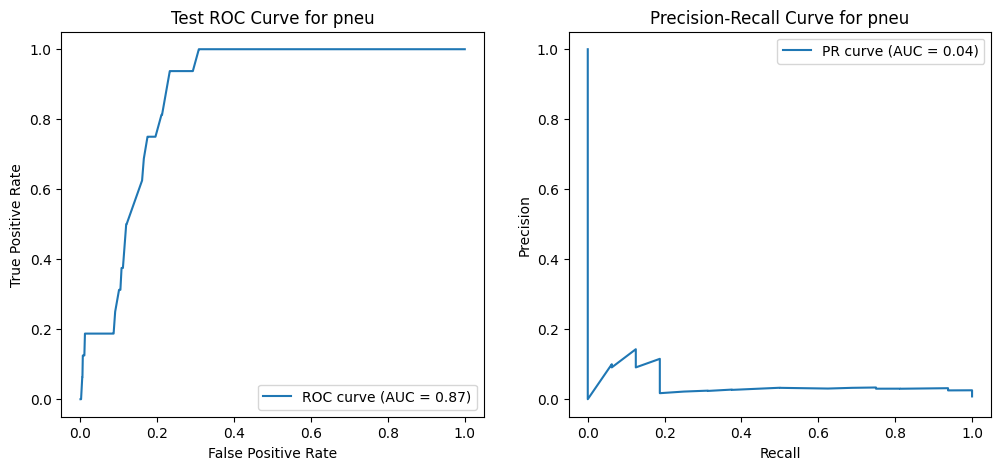

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


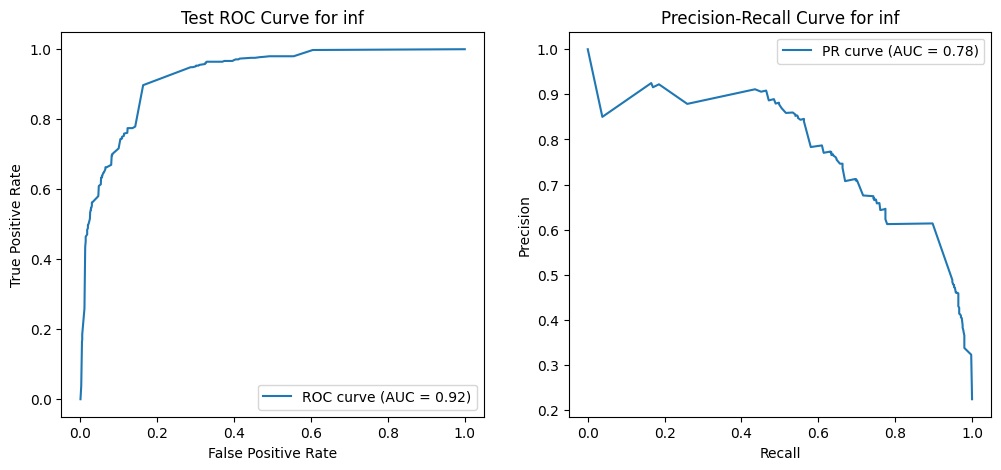

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
nasal - Output shape: (2000,)


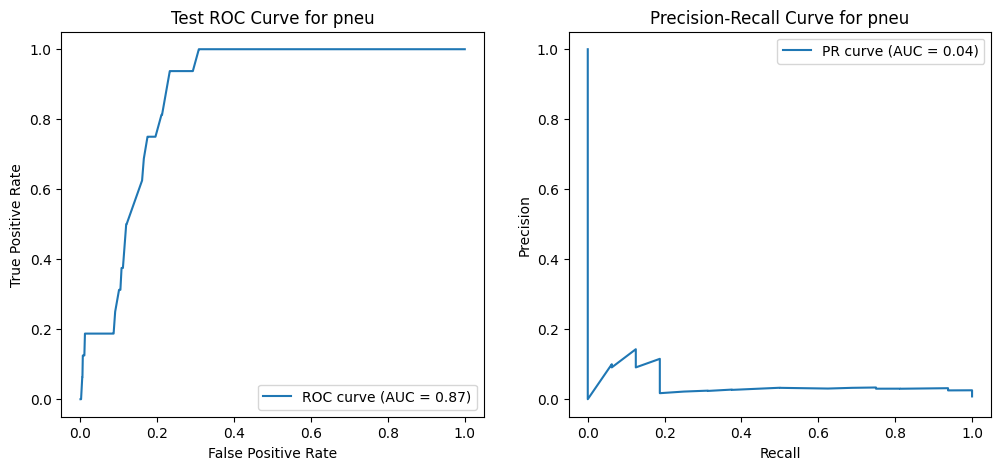

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
dysp - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
cough - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
pain - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
fever - Output shape: (2000,)
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
nasal - Output shape: (2000,)


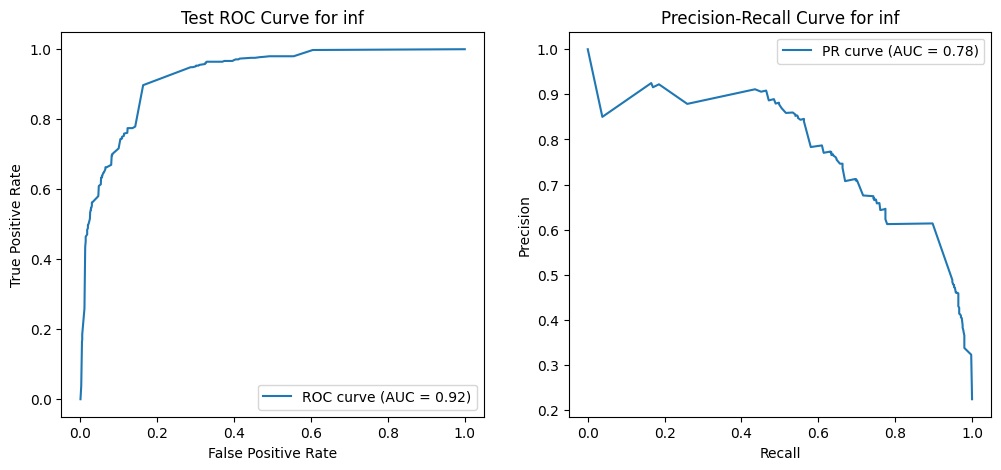

In [14]:
### TEST text -> symps -> target
import tensorflow as tf
import random

seeds = [327, 100, 105, 888, 521]

targets = ["pneu", "inf"]
for seed in seeds:
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    for target in targets:
        y_pred = test(BN_models[target], NN_models, test_df, target, emb='hist_emb')

In [15]:
print("Result for symps")
result

Result for symps


,precision,recall,f1,accuracy
0,0.887097,0.964912,0.924370,0.9685
1,0.957037,0.964179,0.960595,0.9735
2,0.695238,0.776596,0.733668,0.9205
3,0.606062,0.778500,0.681543,0.7785
4,0.951904,0.927734,0.939664,0.9695
